In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import gzip
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression

# Predicting Amazon review scores

Can we predict whether a user will leave a positive or negative review based simply on what they have to say? In theory, we should be able to see some sort of correlation between negative reviews and their choice of words. To evaluate a case study, we'll be taking a look at Amazon review scores from May 1996 - July 2014, specifically their electronics division. 

In [2]:
# Grab and process the raw data.

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

df = getDF('Data\\reviews_Electronics_5.json.gz')

In [3]:
# Prints first 5 rows in our dataframe
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5.0,Gotta have GPS!,1370131200,"06 2, 2013"
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1.0,Very Disappointed,1290643200,"11 25, 2010"
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3.0,1st impression,1283990400,"09 9, 2010"
3,A1H8PY3QHMQQA0,0528881469,"Dave M. Shaw ""mack dave""","[9, 10]","Not going to write a long review, even thought...",2.0,"Great grafics, POOR GPS",1290556800,"11 24, 2010"
4,A24EV6RXELQZ63,0528881469,Wayne Smith,"[0, 0]",I've had mine for a year and here's what we go...,1.0,"Major issues, only excuses for support",1317254400,"09 29, 2011"


In [4]:
# Drop all null values in our dataframe
df = df.dropna()

# Data cleaning
df['summary'] = df['summary'].str.lower()
df['summary'] = df['summary'].str.replace('[^\w\s]','')
df['summary'] = df['summary'].str.strip()

In [5]:
# Prints the dimensions of our dataframe
df.shape

(1664458, 9)

So, if you look at the size of our dataset, you can see that that there are roughly 1.66 million reviews and 9 columns for electronics purchased on Amazon. Now, our dataset will require a bit of preparation before we can use it for our model. The only column that we really need for creating our model will be our 'reviewText' column, which contains what people had to say in their reviews. We will also need our 'overall' column, as that is the review score that we want to predict. As for everything else, while they may help assist us in predicting review scores, the challenge of this assignment is to rely only on text data, so we will be dropping them from our dataset.

In [6]:
# Creating our predictor dataframe
X = df['summary']

# Creating our outcome series
Y = df['overall']

C:\Users\mhuh22\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


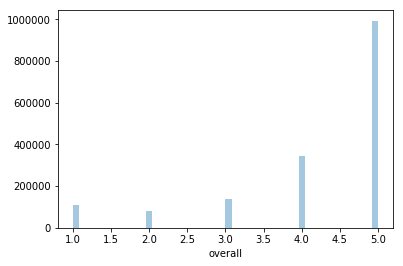

In [7]:
# Plot distribution of review scores
sns.distplot(Y, kde=False)

Based on the distribution of review scores above, we can see that people that review products tend to leave very positive reviews. Since we want to have roughly equal groups in both of our outcomes, we'll have to revise what our definition of a good and bad review are.

C:\Users\mhuh22\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


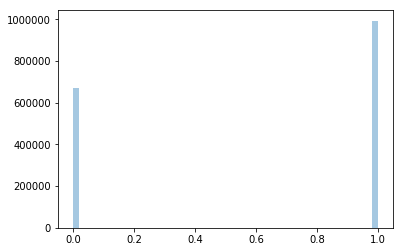

In [8]:
# Let's combine all values lower than 5 into a single value
Y = np.where(Y > 4, 1, 0)

# Plots 1-4 star reviews against 5 star reviews
sns.distplot(Y, kde=False)

If we decide that positive reviews are only perfect 5 star reviews, and everything else (1-4) is an imperfect review, we have enough entries for both outcomes, so we can proceed with the model.

In [9]:
# Import nltk for language processing
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Import our list of stopwords
stop = stopwords.words('english')

# Remove stopwords from the reviews
X = df['summary'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mhuh22\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
X.head()

0                       gotta gps
1                    disappointed
2                  1st impression
3          great grafics poor gps
4    major issues excuses support
Name: summary, dtype: object

In [11]:
X2 = X.sample(frac=0.0001, replace=True)

In [12]:
for i in X2:
    print(i)

real good deal
missing 82mm
works great far
great quality great price
perfect many things well indeed
cannot beat sound quality size
nothing good
works well
great asus tablet case
people know value
nice
good affordable sd usb adapter
perfect fit
exactly described
engineered
good card compatible nikon d800
cable works
large inexpensive
love
great value product
good
lasted less year
foscam fi8910w wireless ip camera black 6999
caveat emptor buy tamron risk
big sticking zipper still like
ok modification
good alarm room works describe
poor warranty support
game console protection plan
perfect
quality basic mouse mat
rewards careful use
25 external hdd case
outstanding piece hardware
works
direct dlink support
sony baloney
excellent camcorder price
nice design beads fall though
backup
really close fit even
portable streetwise camera
cool
cool boombox
good true
useful
nice price nice product
wobble wobble like beyonce song
installed seamlessly immediately recognized win 7 umonitexe crashes w

# Source

Amazon review data - electronics
http://jmcauley.ucsd.edu/data/amazon/